# Домашнее задание на линейные классификаторы
## Логистическая регрессия

## Задание
Реализуйте следующие методы класса методы ``MyLogRegression``:
- ``fit``;
- ``get_grad``. 


**Полезные формулы**:

$$Loss(y, p) = -\sum_{i=1}^{l} (y_i \log (p_i) + (1 - y_i) \log (1 - p_i))$$


$$ \frac{\partial L}{\partial w} = X^T (p - y)$$

<code>[Батч — это небольшой пакет данных одной итерации.](https://neurohive.io/ru/osnovy-data-science/jepoha-razmer-batcha-iteracija/)
</code> 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def logit(x, w):
    return np.dot(x, w)

def sigmoid(h):
    return 1. / (1 + np.exp(-h))

In [9]:
def generate_batches(X, y, batch_size):
    """
    param X: np.array[n_objects, n_features]
    param y: np.array[n_objects] 
    """
    assert len(X) == len(y)
    np.random.seed(42)
    X = np.array(X)
    y = np.array(y)
    
    #print(X)
    #print(y)
    #print("Created the following batches:")
    
    perm = np.random.permutation(len(X))
    num_of_batches = int(len(X) // batch_size)
    
    for i in range(0,len(X) // batch_size ):
          
        perm_start  = i * batch_size
        perm_end = perm_start + batch_size
        p2 = perm[perm_start :  perm_end]
       
        x_give = X[p2]
        y_give = y[p2]

        #print(x_give, y_give)
        yield(x_give, y_give)

In [5]:
class MyLogRegression(object):
    
    def __init__(self):
        self.w = None
        
    def softmax(self, Z, epsilon=1e-9):
        """
        Compute softmax values for each sample of scores in Z
        Z: np.array, shape=[m,k]
        
        return np.array, shape=[m, k]
        """
        e = np.exp(Z - np.max(Z))
        # print(e)
        if e.ndim == 1:
            return e / np.sum(e, axis=0) + epsilon
        else:  
            return e / np.array([np.sum(e, axis=1)]).T + epsilon
        
    def label_matrix(self, y, d):
        '''
        
        param X: features array, shape=[n, k+1], 
        param y: labels array, shape=[1, n], one label per sample
        param d: number of labels
        '''
        n=y.shape[0]

        y_code = np.zeros((n, d))
        y_code[np.arange(n), y] = 1
        return y_code

        
    def fit(self, X, y, epochs=10, lr=0.1, batch_size=1):
        n, k = X.shape
        d = len(np.unique(y))
        if self.w is None:
            np.random.seed(42)
            #Vector column of weights
            self.w = np.random.randn(k + 1, d)
        
        print(self.w)
        X_train = np.concatenate((np.ones((n, 1)), X), axis=1)
        
        losses = []

        #In the losses nn, you need to put a loss on each batch.
        batchn = 0
        for i in range(epochs):
            for X_batch, y_batch in generate_batches(X_train, y, batch_size):
                #print(f"..................Processing batch number {batchn}.................")
                batchn += 1                
                #print("Weights matrix:")
                #print(self.w)
                
                #print("Pre softmaxed:")
                x_w_dot = np.dot(X_batch, self.w)
                #print(x_w_dot)
                
                #print("Predictions matrix:")
                predictions = self.softmax(x_w_dot)
                #print(predictions)
                eta = 0.001
                loss = -np.sum(np.log(predictions) * self.label_matrix(y_batch, d)) + eta / 2 * np.sum(self.w * self.w)

                #assert (np.array(loss).shape == tuple()), "The loss must be a scalar!" 

                losses.append(loss)
                #print("Loss matrix after this iteration:")
                #print(losses)
                
                # Расчет градиента по аналитической формуле:
                grad = self.get_grad(X_batch, y_batch, predictions, d)
                
                # Градиентный спуск с каждым новым пакетом данных:
                step = 0.2
                grad_step = step * grad
                self.w -= grad_step

        return losses
    
    def get_grad(self, X_batch, y_batch, predictions, d):
        """

        param X_batch: np.array[batch_size, n_features + 1] --- matrix of feature objects
        param y_batch: np.array[batch_size] --- batch of target variables
        param predictions: np.array[batch_size] --- butch of probabilities of classes

        Accepts X_batch as input with a column of units already added.
        Outputs the gradient of the loss function in logistic regression
        as the sum of the gradients of the loss function on all butch objects
        Attention! The zero coordinate of the weight vector is BIAS, not the weight of the feature.
        Also, you do not need TO DIVIDE THE GRADIENT BY THE SIZE OF THE BUTCH:
        we are not interested in the average, but the sum.
        As a matrix multiplication operator, you can use @

        Output is a vector column of gradients for each weight (np.array[n_features + 1])
        """
        #gradient component from logregression
        eta = 0.001
        #print("       Inside gradients computation    ")
        #print(y_batch)
        #print(self.label_matrix(y_batch, d))
        #print(predictions)
        grad_basic = -X_batch.T@(self.label_matrix(y_batch, d) - predictions) + eta * self.w
        #assert grad_basic.shape == (X_batch.shape[1],) , "Gradients should be a column of k_features + 1 elements"

        return grad_basic
        
    def predict_proba(self, X):
        n, k = X.shape
        X_ = np.concatenate((np.ones((n, 1)), X), axis=1)
        return self.softmax(logit(X_, self.w))

    def _predict_proba_internal(self, X): 
        return sigmoid(logit(X, self.w))

    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold
    
    def get_weights(self):
        return self.w.copy() 
      
    def __loss(self, y, p):  
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

In [6]:
np.random.seed(42)
m = MyLogRegression()
X = np.random.rand(100,3)
y = np.random.randint(0, 1, size=(100,))
preds = np.random.rand(100)
print(m.w)
#grads = m.get_grad(X, y, preds) 
#assert np.allclose(grads, np.array([23.8698149, 25.27049356, 24.4139452])), "Oops something went wrong!"

None


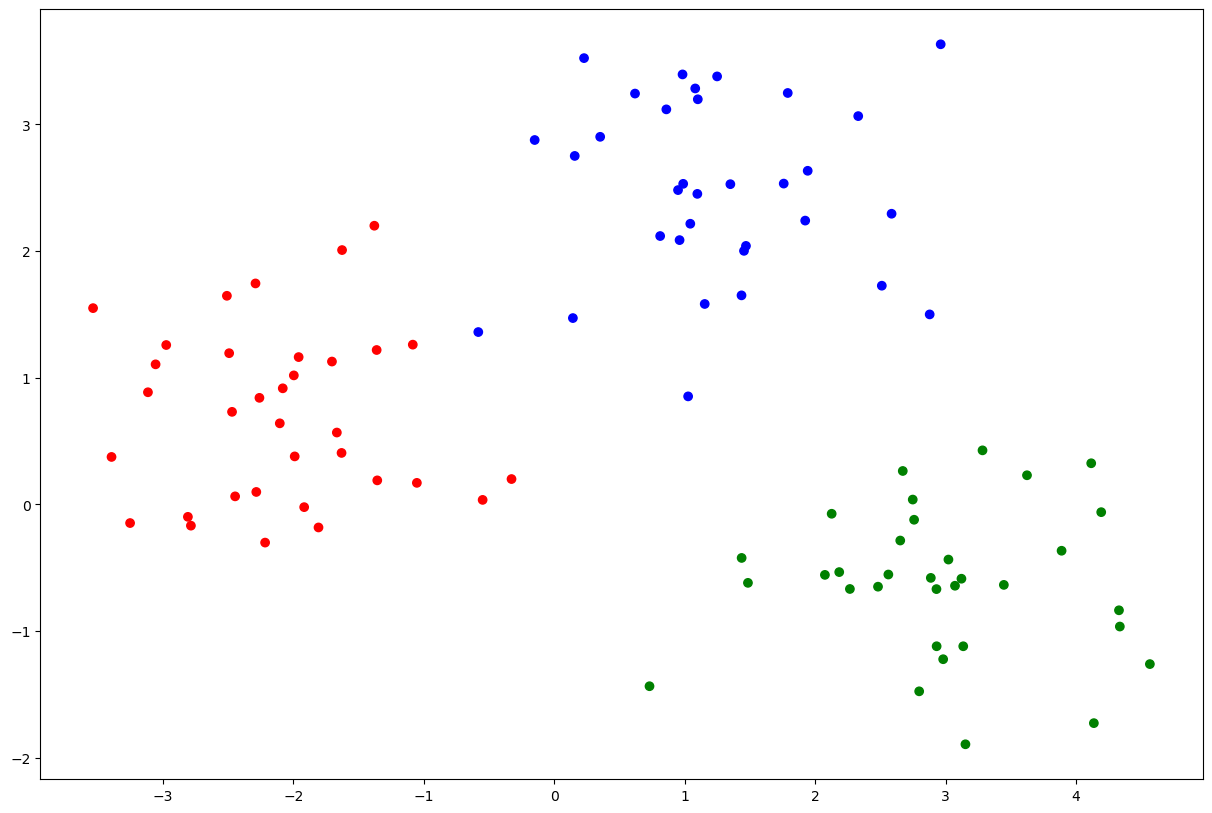

In [7]:
# Визуализация

from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, centers=[[-2,0.5],[3,-0.5],[1,2.5]], cluster_std=0.75, random_state=43)

colors = ("red", "green", "blue")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1,2]):
    colored_y[y == cl] = str(colors[i])
    
#print(colored_y)

plt.figure(figsize=(15,10))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

[[ 0.49671415 -0.1382643   0.64768854]
 [ 1.52302986 -0.23415337 -0.23413696]
 [ 1.57921282  0.76743473 -0.46947439]]


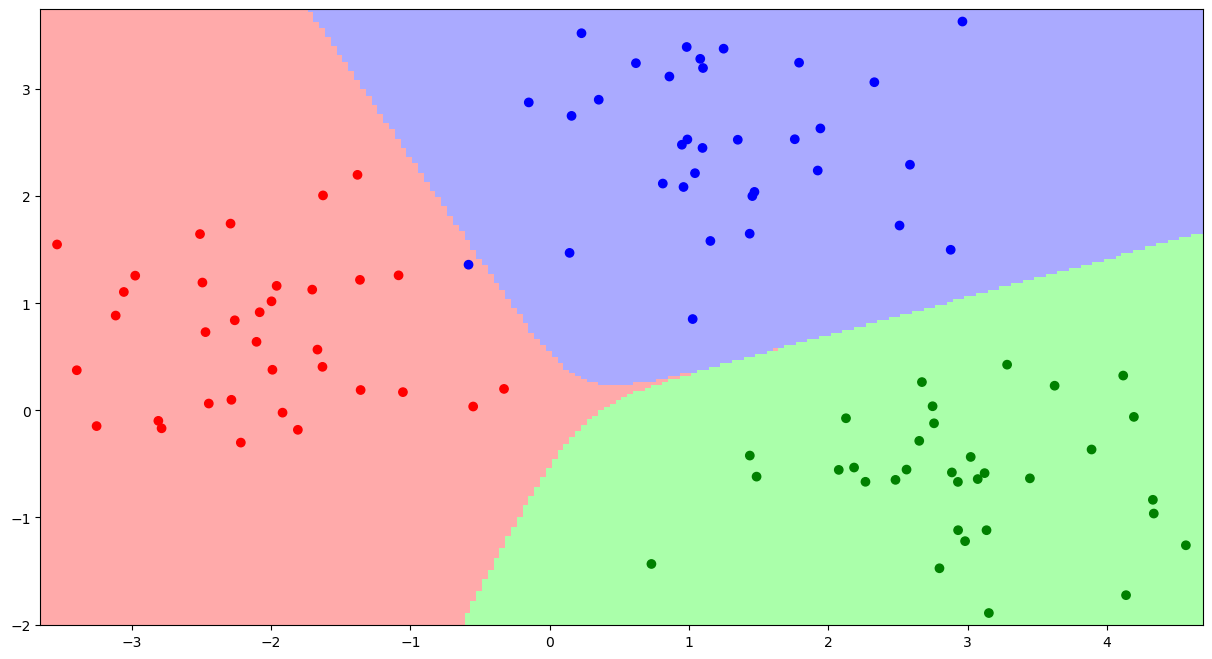

In [10]:
q = MyLogRegression()
q.fit(X, y, epochs = 10)
w = q.get_weights()

from matplotlib.colors import ListedColormap

plt.figure(figsize=(15,8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 200),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 200))

#print(xx)
#print("redraw")
#print(yy)

#print(np.c_[xx.ravel(), yy.ravel()])

#dotproduct  = np.dot(np.c_[xx.ravel(), yy.ravel()], q.w)
#predictions = m.softmax(dotproduct)
#print(predictions)

Z = q.predict(np.c_[xx.ravel(), yy.ravel()])
Q  = np.argmax(Z, axis=1)
#print(Q)

Q = Q.reshape(xx.shape)

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
plt.pcolormesh(xx, yy, Q, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=colored_y)